## 1. 导入库

In [1]:
import os
import sys
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# 添加 UniMatch-V2 到路径
sys.path.insert(0, './UniMatch-V2')

from model.semseg.dpt import DPT
from util.classes import CLASSES

xFormers not available
xFormers not available


## 2. 配置参数

In [2]:
# 配置文件和检查点路径
config_path = './UniMatch-V2/configs/coco.yaml'
checkpoint_path = './data/kaggle/seminar-rs-coco-trainning-test/UniMatch-V2/exp/coco/unimatch_v2/dinov2_small/custom_small/best.pth'

# 加载配置
with open(config_path, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.Loader)

print('配置参数:')
print(f"数据集: {cfg['dataset']}")
print(f"类别数: {cfg['nclass']}")
print(f"Backbone: {cfg['backbone']}")
print(f"输入尺寸: {cfg['crop_size']}")

配置参数:
数据集: coco
类别数: 81
Backbone: dinov2_small
输入尺寸: 518


## 3. 加载模型

In [4]:
# 模型配置
model_configs = {
    'small': {'encoder_size': 'small', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'base': {'encoder_size': 'base', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'large': {'encoder_size': 'large', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'giant': {'encoder_size': 'giant', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

# 创建模型
backbone_size = cfg['backbone'].split('_')[-1]
model = DPT(**{**model_configs[backbone_size], 'nclass': cfg['nclass']})

# 加载检查点
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# 从 DistributedDataParallel 格式加载权重
state_dict = checkpoint['model_ema']  # 使用 EMA 模型通常效果更好
new_state_dict = {}
for k, v in state_dict.items():
    # 去掉 'module.' 前缀
    name = k[7:] if k.startswith('module.') else k
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

# 如果有 GPU，使用 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'模型加载成功！')
print(f'使用设备: {device}')
print(f'检查点 epoch: {checkpoint["epoch"]}')
print(f'最佳 mIoU: {checkpoint["previous_best"]:.2f}%')
print(f'最佳 mIoU (EMA): {checkpoint["previous_best_ema"]:.2f}%')

模型加载成功！
使用设备: cuda
检查点 epoch: 19
最佳 mIoU: 21.46%
最佳 mIoU (EMA): 21.42%


## 4. 图像预处理

In [9]:
def preprocess_image(image_path, size=518):
    """加载和预处理图像"""
    # 读取图像
    img = Image.open(image_path).convert('RGB')
    original_size = img.size

    # 预处理
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0)  # 添加 batch 维度

    return img_tensor, img, original_size

def postprocess_mask(pred, original_size):
    """后处理预测结果"""
    # 将预测 resize 回原始尺寸
    pred = torch.nn.functional.interpolate(
        pred.unsqueeze(0).unsqueeze(0).float(),
        size=original_size[::-1],  # (height, width)
        mode='nearest'
    ).squeeze(0).squeeze(0).long()

    return pred.cpu().numpy()

print('预处理函数定义完成')

预处理函数定义完成


## 5. 推理函数

In [6]:
@torch.no_grad()
def inference(image_path, model, device):
    """对单张图片进行推理"""
    # 预处理
    img_tensor, original_img, original_size = preprocess_image(image_path)
    img_tensor = img_tensor.to(device)

    # 推理
    pred = model(img_tensor)
    pred = pred.argmax(dim=1).squeeze(0)  # 获取类别预测

    # 后处理
    pred_mask = postprocess_mask(pred, original_size)

    return original_img, pred_mask

print('推理函数定义完成')

推理函数定义完成


## 6. 可视化函数

In [7]:
def visualize_prediction(original_img, pred_mask, dataset='coco', alpha=0.5):
    """可视化预测结果"""
    # 创建颜色映射
    np.random.seed(42)
    colors = np.random.randint(0, 255, (cfg['nclass'], 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # 背景设为黑色

    # 将预测掩码转换为彩色图
    colored_mask = colors[pred_mask]

    # 创建可视化
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 原始图像
    axes[0].imshow(original_img)
    axes[0].set_title('原始图像', fontsize=14)
    axes[0].axis('off')

    # 预测掩码
    axes[1].imshow(colored_mask)
    axes[1].set_title('预测掩码', fontsize=14)
    axes[1].axis('off')

    # 叠加显示
    original_np = np.array(original_img)
    overlay = (original_np * alpha + colored_mask * (1 - alpha)).astype(np.uint8)
    axes[2].imshow(overlay)
    axes[2].set_title('叠加显示', fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 显示类别统计
    unique_classes = np.unique(pred_mask)
    print(f'\n检测到的类别数: {len(unique_classes)}')
    print('\n类别统计:')
    for cls_id in unique_classes:
        pixel_count = np.sum(pred_mask == cls_id)
        percentage = 100.0 * pixel_count / pred_mask.size
        class_name = CLASSES[dataset][cls_id] if cls_id < len(CLASSES[dataset]) else f'Class-{cls_id}'
        print(f'  [{cls_id:2d}] {class_name:20s}: {percentage:6.2f}%')

print('可视化函数定义完成')

可视化函数定义完成


## 7. 运行推理

正在处理图像: ./data/tmp-test/000000000229.jpg


/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12700/950678349.py:31: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}

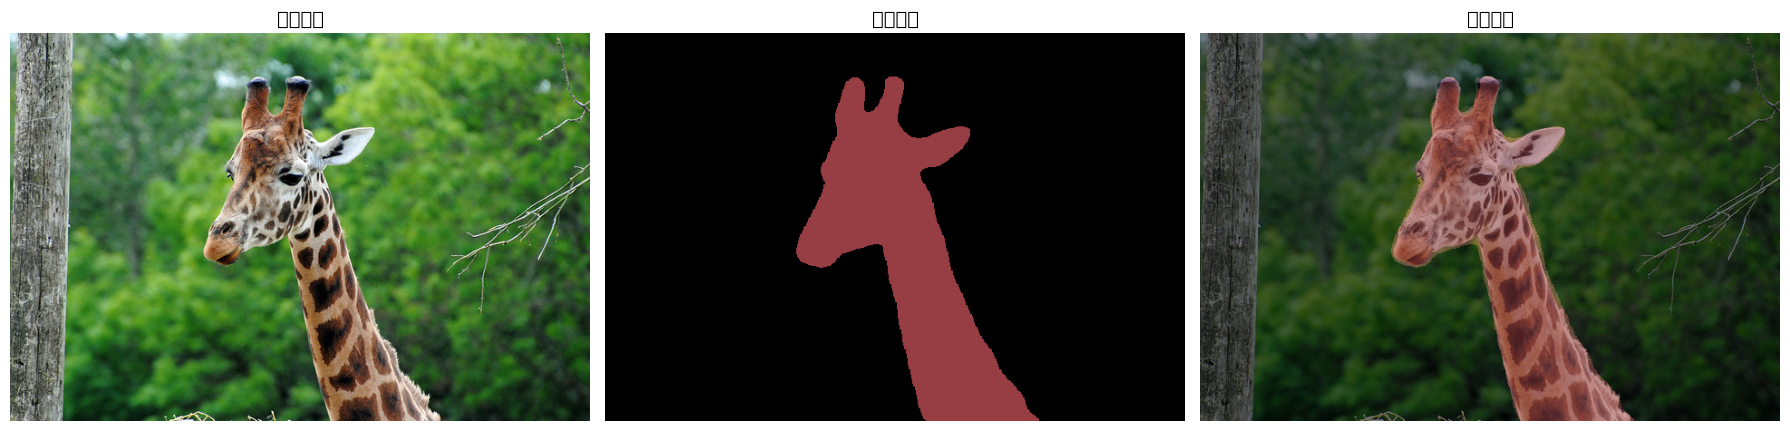


检测到的类别数: 2

类别统计:
  [ 0] void                :  85.74%
  [24] giraffe             :  14.26%

推理完成！


In [11]:
# 指定要推理的图像路径
# 请修改为你的图像路径
image_path = './data/tmp-test/000000000229.jpg'  # 修改此路径

# 检查文件是否存在
if not os.path.exists(image_path):
    print(f'错误: 图像文件不存在: {image_path}')
    print('请修改 image_path 变量为有效的图像路径')
else:
    # 执行推理
    print(f'正在处理图像: {image_path}')
    original_img, pred_mask = inference(image_path, model, device)

    # 可视化结果
    visualize_prediction(original_img, pred_mask, dataset=cfg['dataset'])

    print('\n推理完成！')

In [14]:
CLASSES["coco"][21]

'elephant'

## 8. 批量推理（可选）

In [ ]:
# 批量处理文件夹中的所有图像
def batch_inference(image_folder, output_folder=None):
    """批量推理文件夹中的所有图像"""
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)

    # 支持的图像格式
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    # 获取所有图像文件
    image_files = []
    for ext in valid_extensions:
        image_files.extend(list(Path(image_folder).glob(f'*{ext}')))
        image_files.extend(list(Path(image_folder).glob(f'*{ext.upper()}')))

    print(f'找到 {len(image_files)} 张图像')

    for i, img_path in enumerate(image_files):
        print(f'\n处理 [{i+1}/{len(image_files)}]: {img_path.name}')

        try:
            original_img, pred_mask = inference(str(img_path), model, device)

            if output_folder:
                # 保存预测结果
                output_path = os.path.join(output_folder, f'{img_path.stem}_pred.png')
                Image.fromarray(pred_mask.astype(np.uint8)).save(output_path)
                print(f'保存到: {output_path}')
            else:
                # 显示结果
                visualize_prediction(original_img, pred_mask, dataset=cfg['dataset'])

        except Exception as e:
            print(f'处理失败: {e}')
            continue

    print(f'\n批量推理完成！')

# 使用示例（取消注释以使用）:
# from pathlib import Path
# batch_inference('./data/test_images', './data/predictions')

## 9. 保存预测结果（可选）

In [ ]:
# 如果需要保存预测掩码
def save_prediction(pred_mask, output_path):
    """保存预测掩码"""
    Image.fromarray(pred_mask.astype(np.uint8)).save(output_path)
    print(f'预测掩码已保存到: {output_path}')

# 使用示例（取消注释以使用）:
# save_prediction(pred_mask, './output/prediction.png')